## Q5: Attention and Transformers (5 Pts)

#### What differences and advantages do transformers show over recurrent neural networks (1 pt)?

Transformers have two important advantages over RNNs:
1. Parallelization
  - In RNNs, input sequences are processed sequentially as the encoding (hidden state) of the current token depends on the hidden state of the previous token
  - In Transformers, input sequences of a fixed context window are processed as a whole.
2. Long-range dependencies
- RNNs struggle to capture long-range dependencies as the current hidden state has direct access to the previous hidden state only
- in Transformers, the current hidden state can access all previous token encodings

Source: Large Language Models ETH course

#### Implement, train, and test a simple transformer model (2 pts)

In [1]:
%load_ext autoreload
%autoreload 2

In [158]:
import os
import pandas as pd
import torch
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score
from google.colab import drive
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

Load data

In [6]:
train = pd.read_csv("ptbdb_train.csv", header=None)
test = pd.read_csv("ptbdb_test.csv", header=None)

Prepare data

In [7]:
X_train = train.iloc[:,0:-1]
y_train = train.iloc[:,-1]

X_test = test.iloc[:,0:-1]
y_test = test.iloc[:,-1]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((11641, 187), (11641,), (2911, 187), (2911,))

In [8]:
BATCH_SIZE = 32

In [9]:
y_train.value_counts() / y_train.shape[0]

187
1.0    0.721931
0.0    0.278069
Name: count, dtype: float64

In [10]:
# train val split
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [11]:
y_train_val.value_counts() / y_train_val.shape[0]

187
1.0    0.728105
0.0    0.271895
Name: count, dtype: float64

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [13]:
torch.manual_seed(0)

# prepare train data
train_train_dataset = TensorDataset(
    torch.tensor(X_train_train.to_numpy()).float().to(device),
    torch.tensor(y_train_train.to_numpy()).float().to(device))
train_train_loader = DataLoader(train_train_dataset, shuffle=True, batch_size=BATCH_SIZE)

# validation data
train_val_dataset = TensorDataset(
    torch.tensor(X_train_val.to_numpy()).float().to(device),
    torch.tensor(y_train_val.to_numpy()).float().to(device))
train_val_loader = DataLoader(train_val_dataset, batch_size=BATCH_SIZE)

In [21]:
from transformer import TimeSeriesClassifierTransformer, train_transformer

model = TimeSeriesClassifierTransformer(
    seq_len=187,
    d_model=64,
    num_layers=3,
    num_heads=8,
    dropout=0.0,
    dim_feedforward=128,
    activation="gelu"
).to(device)

In [155]:
print(model)

TimeSeriesClassifierTransformer(
  (embed): Linear(in_features=1, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayerCustom(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
    )
    (linear1): Linear(in_features=64, out_features=128, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (linear2): Linear(in_features=128, out_features=64, bias=True)
    (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.0, inplace=False)
    (dropout2): Dropout(p=0.0, inplace=False)
  )
  (transformer_encoder): TransformerEncoderCustom(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayerCustom(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_fea

In [22]:
train_transformer(
    model=model,
    epochs=50,
    batch_size=BATCH_SIZE,
    train_loader=train_train_loader,
    val_loader=train_val_loader,
    val_score=f1_score,
    lr=0.0003,
    weight_decay=0.0001,
)

epoch: 0, train loss: 0.5917379330469953, validation score: 0.8377775167391048
epoch: 1, train loss: 0.5690637133460986, validation score: 0.8377775167391048
epoch: 2, train loss: 0.5562397408446833, validation score: 0.8377775167391048
epoch: 3, train loss: 0.5470067239502101, validation score: 0.8377775167391048
epoch: 4, train loss: 0.5433800794352991, validation score: 0.8375726957645538
epoch: 5, train loss: 0.5352936468078094, validation score: 0.8331751305173233
epoch: 6, train loss: 0.5340062640245679, validation score: 0.8282803929841479
epoch: 7, train loss: 0.5264413449370745, validation score: 0.8368626523127883
epoch: 8, train loss: 0.5073993185770165, validation score: 0.8478027189377174
epoch: 9, train loss: 0.48518710595504366, validation score: 0.8510234512674529
epoch: 10, train loss: 0.4562981393441413, validation score: 0.8598249397437524
epoch: 11, train loss: 0.4462392751163649, validation score: 0.86247947454844
epoch: 12, train loss: 0.43010929593376357, validat

In [23]:
torch.save(model.state_dict(), "ts_clf_trafo_50epochs.pt")

Performance on test set

In [25]:
# prepare test data
X_test_dataset = torch.tensor(X_test.to_numpy()).float().to(device)
test_dataset = TensorDataset(
    torch.tensor(X_test.to_numpy()).float().to(device),
    torch.tensor(y_test.to_numpy()).float().to(device)
    )
test_batch_size = 1
test_loader = DataLoader(test_dataset, batch_size=test_batch_size)

In [28]:
model.eval()
y_pred = []
for nr_batch, (X_batch, y_batch) in enumerate(test_loader):
  y_pred_batch, _ = model(X_batch)
  y_pred.append(y_pred_batch.squeeze().cpu().detach().numpy().round())

In [160]:
accuracy_score(y_pred, y_test), f1_score(y_pred, y_test), balanced_accuracy_score(y_pred, y_test)

(0.880109927859842, 0.917630398867123, 0.8534651971317511)

Visualize the attention map learned by your model using input layer weights. Do you gain any insight on important data points to distinguish between normal and abnormal sequences (2 pts)?

In [163]:
def aggregate_layer_weights(weights: list, strategy: str):
  if strategy == "mean":
    w_sum = torch.zeros(weights[0].shape).to(device)
    for w in weights:
      w_sum += w
    mean_attn_weight_matrix = w_sum / len(weights)
    return mean_attn_weight_matrix
  elif strategy == "input_layer":
    return weights[0]
  else:
    raise NotImplementedError


def get_predictions(model, data_loader, strategy):
  model.eval()
  y_pred = []
  weights = []
  for nr_batch, (X_batch, y_batch) in enumerate(data_loader): # batch size is 1

    y_pred_batch, weight_batch = model(X_batch)
    y_pred.append(int(y_pred_batch.squeeze().cpu().detach().numpy().round()))
    if len(weight_batch) > 1: # if num_layers > 1, weight_batch is a list of len = num_layers
        weights.append(aggregate_layer_weights(weight_batch, strategy))
    else:
      weight_batch = weight_batch[0]
      weights.append(weight_batch)

  return y_pred, weights

y_pred, attn_weight_matrices = get_predictions(model, test_loader, strategy="input_layer")
assert attn_weight_matrices[0].shape == torch.Size([1, 187, 187])

In [164]:
def flatten_attn_weight_matrix(attn_matrix):
  return attn_matrix.squeeze(0).mean(dim=0).cpu().detach().numpy()

# get attn vectors for each time series
attn_weights = []
for attn_matrix in attn_weight_matrices:
  attn_weights.append(flatten_attn_weight_matrix(attn_matrix))

assert attn_weights[0].shape == (187,)

In [165]:
is_ok = np.array(y_test) == np.array(y_pred)
is_1 = np.array(y_test) == 1
is_0 = np.array(y_test) == 0

In [166]:
ix_1 = np.arange(0,len(y_test))[is_ok & is_1]
ix_0 = np.arange(0,len(y_test))[is_ok & is_0]

In [167]:
ix_1.shape

(1944,)

In [168]:
ix_0.shape

(618,)

In [169]:
n_ex_per_class = 4
ex_1 = np.random.choice(ix_1, n_ex_per_class) # [2068, 471, 2697, 774]
ex_0 = np.random.choice(ix_0, n_ex_per_class) # [58, 1917, 2555, 486]

In [170]:
def plot_ts_and_attn_weights(ts, weights, ax, cmap):

  # plot time series
  ax.plot(ts, color="black")

  # plot attention weights
  ax.pcolormesh([weights]*2, cmap=cmap, shading='gouraud')

  # colorbar
  sm = ScalarMappable(cmap=cmap)
  sm.set_array(weights)
  cbar = plt.colorbar(sm, ax=ax)
  cbar.set_label('Average Attention Weight')

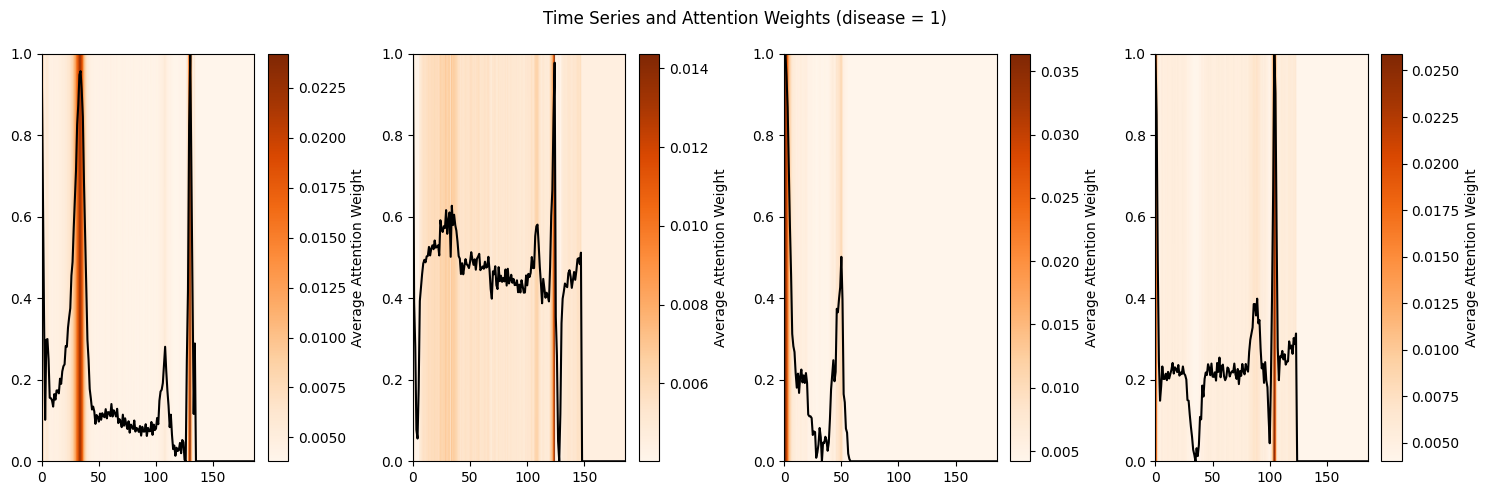

In [171]:
title = "Time Series and Attention Weights (disease = 1)"
examples = [2068, 471, 2697, 774]
cmap = 'Oranges'

fig, ax = plt.subplots(1, n_ex_per_class, figsize=(15,5))

for i in range(len(examples)):
  ix = examples[i]
  ts = X_test.cpu().numpy()[ix,:]
  attn_ts = attn_weights[ix]
  plot_ts_and_attn_weights(ts, attn_ts, ax[i], cmap)

plt.suptitle(title)
plt.tight_layout()
plt.show()

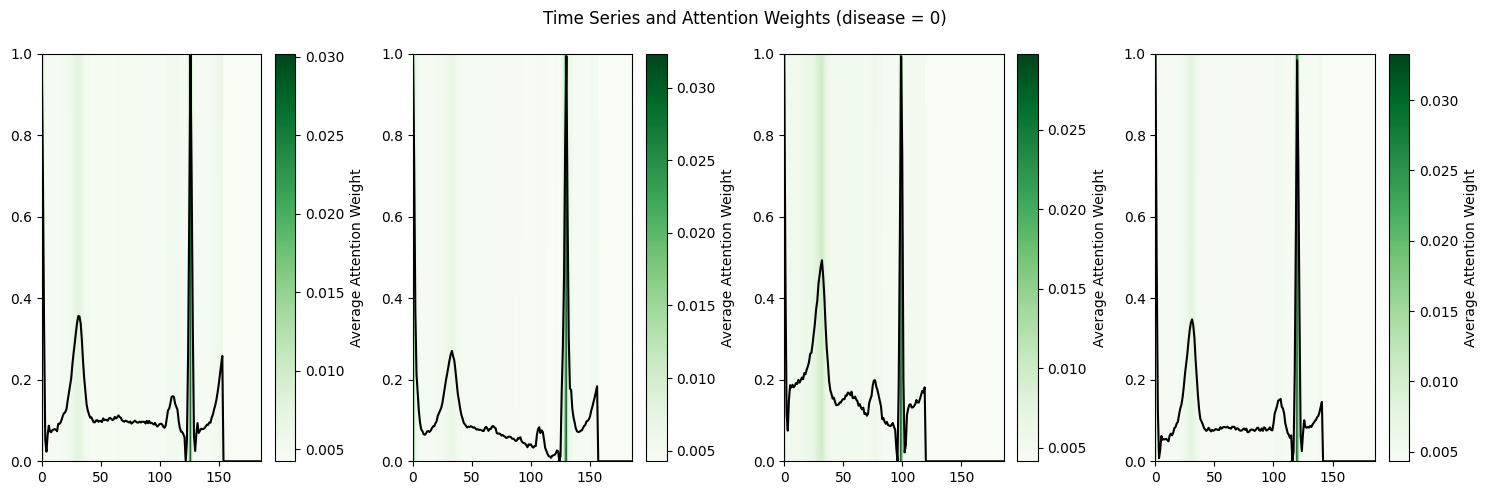

In [172]:
title = "Time Series and Attention Weights (disease = 0)"
examples = [58, 1917, 2555, 486]
cmap = 'Greens'

fig, ax = plt.subplots(1, n_ex_per_class, figsize=(15,5))

for i in range(len(examples)):
  ix = examples[i]
  ts = X_test.cpu().numpy()[ix,:]
  attn_ts = attn_weights[ix]
  plot_ts_and_attn_weights(ts, attn_ts, ax[i], cmap)

plt.suptitle(title)
plt.tight_layout()
plt.show()